In [1]:
import os
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 12, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages

import itertools as it
import venn


def save_pdf(save_file, fig):
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight',dpi=300)
    pdf.close()
    return


In [10]:
def get_gene_set_from_file(gene_file):
    with open(gene_file, "r") as f:
        genes = set([g.strip() for g in f.readlines()])
    return genes
    
def get_genes_df(g, gl):
    df = pd.DataFrame(g, columns=["gene"])
    df["label"] = gl
    return df

def get_intersecting_num(gene_sets, prod):
    sign = [-1 if p==0 else 1 for p in prod]
    sign_dict = {idx: s for idx,s in zip(range(len(prod)), sign)}
    # get the positive signs first
    sign_dict = dict(sorted(sign_dict.items(), key=lambda item:item[1], reverse=True))
    for i, (k,v) in enumerate(sign_dict.items()):
        if i == 0:
            assert v==1
            final_set = gene_sets[k]
        else:
            if v==-1:
                final_set = final_set.difference(gene_sets[k])
            else:
                assert v==1
                final_set = final_set.intersection(gene_sets[k])
    return len(final_set)

def create_gene_sets_for_venn(genes, labels):
    genes_df = pd.concat([get_genes_df(g,gl) for g,gl in zip(genes, labels)])
    genes_dict = genes_df.groupby("label").agg({"gene": lambda x: set(x)}).to_dict()["gene"]
    gene_labels, gene_sets = list(genes_dict.keys()), list(genes_dict.values())

    subset_dict = dict()
    for prod in list(it.product([0, 1], repeat=len(labels))):
        if all(p == 0 for p in prod):
            continue
        else:
            subset_dict["".join(list(map(str, prod)))] = get_intersecting_num(gene_sets, prod)
    # gene_labels_colors_dict = {"combinations": "#524FA1", "gwas": "#F68B1F", "mgi": "#D1DE76", "previous studies": "#BC668B"}
    # colors=[gene_labels_colors_dict[gl] for gl in gene_labels]
    default_colors = [
        # r, g, b, a
        [82, 79, 161, 0.5], #[90, 155, 212, 0.5],
        [246, 139, 31, 0.5],#[241, 90, 96, 0.4],
        [209, 222, 118, 0.3], #[92, 192, 98, 0.5],
        [188, 102, 139, 0.2], #[82, 82, 190, 0.2],
        [246, 236, 86, 0.6],
        [255, 117, 0, 0.3],
    ]
    default_colors = [
        [i[0] / 255.0, i[1] / 255.0, i[2] / 255.0, i[3]]
        for i in default_colors
    ]
    fig, ax = venn.venn4(subset_dict, names=gene_labels, colors=default_colors, figsize=(6, 6))
    return fig, genes_dict

In [3]:
sig_meta_res_df = pd.read_excel("../data/meta/monogenic_meta.xlsx")

In [4]:
study_genes = set(sig_meta_res_df.ID.str.split(".", expand=True).iloc[:, 0])

In [21]:
rvas_genes = set([
    "ZBTB7B","ACHE","RAPGEF3","PRKAG1","RAB21","KSR2","HIP1R","ZFHX3","GIPR","ENTPD6", "MC4R",  #turcot # "ZFR2","ZNF169","SLC6A17","MAP1A","ALDH3A1","ANGPTL7","ZNF169",
    "PHIP", "DGKI", "ZMYM4", #marenne
    "ADCY3", "AGRP", "BDNF", "KSR2", "LEP", "LEPR", "MRAP2", "NTRK2", "PCSK1", "PHIP", "SH2B1", "POMC", "SIM1", #loos 
    "UHMK1", "GPR75", "ROBO1", "KIAA1109","PCSK1","GPR151","SPARC","CALCR","PDE3B","ANO4","KIAA0586","DPP9","ANKRD27", "UBR2", "GIPR",#akbari 
    "BSN", "APBA1", "TOX4", "ATP13A1" # zhao # 
])



In [22]:
gwas_genes = pd.read_csv("../data/known_genes/gwas_genes.txt", header=None)
gwas_genes = set(gwas_genes.iloc[:, 0])

/Users/deeprobanerjee/miniconda3/envs/analysis/lib/python3.10/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn3()` is retained for backwards compatibility; use `venn()` instead
  warn((


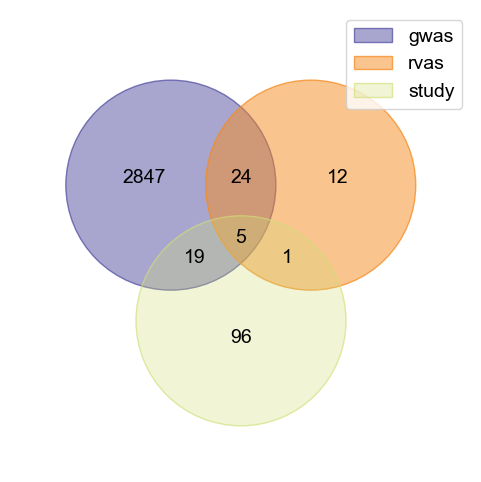

In [23]:
fig, genes_dict = create_gene_sets_for_venn([gwas_genes, rvas_genes, study_genes], ["gwas", "rvas", "study"])

In [24]:
save_pdf("../data/known_genes/overlap.pdf", fig)

In [15]:
genes_dict["gwas"].intersection(genes_dict["rvas"]).intersection(genes_dict["study"])

{'BSN', 'MC4R', 'UBR2'}

In [25]:
genes_dict["rvas"].intersection(genes_dict["study"])

{'APBA1', 'BSN', 'MC4R', 'POMC', 'ROBO1', 'UBR2'}

In [11]:
len(study_genes.intersection(gwas_genes.union(rvas_genes)))

25

In [15]:
len(study_genes.intersection(gwas_genes.difference(rvas_genes)))

21

In [16]:
len(study_genes.intersection(gwas_genes))

24

In [ ]:
all_studies = [
    "/data7/deepro/ukb_bmi/3_characterization/data/combo_info/british/combo_genes.list", 
    "/data7/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/gwas/data/gwas_genes.txt", 
    "/data7/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/mgi/data/mgi_genes.txt", 
    "/data7/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/marenne/data/marenne_genes.txt", 
    "/data7/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/locke/data/locke_genes.txt", 
    "/data7/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/akbari_2021/data/akbari_genes.list", 
    "/data7/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/turcot_2018/data/turcot_genes.list",
    "/data7/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/loos_2021/data/loos_genes_risk.list"
]

all_studies_labels = [
    "combinations",
    "gwas",
    "mgi",
    "previous studies",
    "previous studies",
    "previous studies",
    "previous studies",
    "previous studies"
]

In [ ]:


genes = list(map(get_gene_set_from_file, all_studies))
fig, genes_dict = create_gene_sets_for_venn(genes, all_studies_labels)



In [26]:
bmi_cat_df = pd.read_excel("../data/manual_lit/monogenic_lit_review.xlsx")

In [29]:
bmi_cat_df.head()

,gene,beta,nu,ovw,ob,sob,rvas,gwas,gtex,pathways,mouse_pheno,BMI_HuGE_score,HuGE_Strong_phenotypes
0,DCUN1D3,-3.842606,enriched,NaN,NaN,NaN,False,False,Adipose_Visceral_Omentum|Nerve_Tibial|Adipose_...,Metabolism of proteins|Post-translational prot...,thrombocytopenia|decreased circulating HDL cho...,1.0,eGFRcreaNoDiabetes
1,NEUROD6,-3.024546,enriched,NaN,NaN,NaN,False,False,Brain_Frontal_Cortex_BA9|Brain_Cortex|Brain_An...,Gene symbol not in pug,Mouse not phenotyped,1.0,NaN
2,SH3GL2,-2.339171,enriched,depleted,NaN,NaN,False,False,Brain_Cerebellar_Hemisphere|Brain_Cerebellum|B...,EPHB forward signaling|Internalization of ErbB...,decreased grip strength|decreased exploration ...,1.0,Parkinsons|HIPKNEEOA
3,AQP3,-2.055961,enriched,NaN,depleted,depleted,False,False,Esophagus_Mucosa|Vagina|Skin_Not_Sun_Exposed_S...,Kidney Function|Kidney Function - Collecting D...,increased circulating alkaline phosphatase lev...,1.0,Eczema
4,RABEP1,-1.709539,NaN,NaN,depleted,NaN,False,True,Cells_EBV-transformed_lymphocytes|Brain_Spinal...,Membrane Trafficking|Vesicle-mediated transpor...,Mouse not phenotyped,3.0,HEIGHT|SHBGadjBMI|CHOL|TG|nonHDL|MeanSpheredVo...


In [33]:
bmi_cat_df.loc[(bmi_cat_df.rvas==False)&(bmi_cat_df.gwas==False)&((bmi_cat_df.BMI_HuGE_score>=10)|(bmi_cat_df.HuGE_Strong_phenotypes.str.contains("BMI|Obesity")))]

,gene,beta,nu,ovw,ob,sob,rvas,gwas,gtex,pathways,mouse_pheno,BMI_HuGE_score,HuGE_Strong_phenotypes
19,ZNF627,-0.755412,NaN,NaN,NaN,NaN,False,False,Cervix_Endocervix|Cervix_Ectocervix|Ovary|Uter...,Gene symbol not in pug,Mouse not phenotyped,1.0,PlatVol|CAD|FIadjBMI|TGnonT2D|PlatCount
20,COLEC11,-0.718003,enriched,NaN,NaN,NaN,False,False,Ovary|Liver|Adrenal_Gland|Heart_Atrial_Appenda...,Complement cascade|Lectin pathway of complemen...,Mouse not phenotyped,1.0,SHBGadjBMI|Hematocrit|TGtoHDL|GFATadjBMIHeight...
23,RASSF3,-0.667651,NaN,depleted,enriched,enriched,False,False,Artery_Tibial|Colon_Sigmoid|Artery_Aorta|Arter...,Pleural mesothelioma,Mouse not phenotyped,1.0,PI|WBC|FEV1toFVC|PlatCount|LymphoPerc|HR|NeutC...
29,LAMB2,-0.591434,enriched,NaN,depleted,depleted,False,False,Artery_Aorta|Ovary|Artery_Tibial|Cervix_Ectoce...,a6b1 and a6b4 Integrin signaling|Beta1 integri...,Mouse not phenotyped,20.0,MI|HEIGHT|Men|SHBGadjBMI|PRI|Ap-LM|WHR|Neuroti...
33,SETX,-0.541832,enriched,NaN,NaN,NaN,False,False,Testis|Cells_EBV-transformed_lymphocytes|Thyro...,Interactome of polycomb repressive complex 2 (...,male infertility|decreased leukocyte cell numb...,1.0,PlatDistWidth|FIadjBMI|ALP|PlatCount|TB-LM
38,PI4KB,-0.483687,depleted,NaN,enriched,NaN,False,False,Nerve_Tibial|Uterus|Thyroid|Fallopian_Tube|Cer...,"D-myo-inositol (1,4,5)-trisphosphate biosynthe...",Mouse not phenotyped,1.0,Ap-LM|Ca|SHBGadjBMI|ApoA|HDL|T2D|EosinCount|SH...
46,AHNAK,-0.411651,NaN,NaN,NaN,NaN,False,False,Nerve_Tibial|Colon_Sigmoid|Cells_Cultured_fibr...,Gene symbol not in pug,increased large unstained cell number|preweani...,3.0,TL|AST_ALT_ratio|CHOL|AST|WHRadjBMI|ForearmFra...
47,FARP2,-0.398751,NaN,NaN,NaN,NaN,False,False,Testis|Cells_Cultured_fibroblasts|Cells_EBV-tr...,Regulation of CDC42 activity|Nectin adhesion p...,decreased circulating magnesium level,350.0,BMI|GGT|RedCount|NeutCount|SBP|MeanCorpHb|IGF1...
57,CYP3A5,-0.331510,enriched,NaN,depleted,NaN,False,False,Liver|Small_Intestine_Terminal_Ileum|Skin_Not_...,Tryptophan degradation ( Tryptophan degradatio...,Mouse not phenotyped,3.0,SHBGadjBMI|ReticuloPerc|NeutroPerc|PlatCount|R...
60,NALCN,-0.319730,enriched,NaN,depleted,NaN,False,False,Brain_Cerebellar_Hemisphere|Brain_Cerebellum|B...,Stimuli-sensing channels|Transport of small mo...,increased neutrophil cell number|spina bifida|...,1.0,FIadjBMI|IPFSurvival|UterineFibroids_HMB|Obesity
